# 특성 (Feature) 공학과 규제 (Regularization; 정형화, 규제, 일반화)
- 규제는 과대적합이 되지 않도록 모델을 강제로 제한함.

In [73]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv('../Data/fish.csv')

In [75]:
# Numpy 변환
fish_full = df.to_numpy()
fish_full[0:6]
# length, height, width

array([[ 8.4 ,  2.11,  1.41],
       [13.7 ,  3.53,  2.  ],
       [15.  ,  3.82,  2.43],
       [16.2 ,  4.59,  2.63],
       [17.4 ,  4.59,  2.94],
       [18.  ,  5.22,  3.32]])

In [76]:
df = pd.read_csv('../Data/fish_weight.csv')

In [77]:
# Numpy 변환
fish_weight = df.to_numpy()
fish_weight[0:6]

array([[  5.9],
       [ 32. ],
       [ 40. ],
       [ 51.5],
       [ 70. ],
       [100. ]])

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
train_input, test_input, train_target, test_target = train_test_split(fish_full,fish_weight, random_state=42)

### Scikit-learn으로 다중회귀 분석하기
- Feature가 length, height, width로 세 개이므로 다항이 아닌 다중회귀로 분석한다

In [80]:
from sklearn.preprocessing import PolynomialFeatures

---
### 다항 특성 만들기 연습

In [81]:
poly = PolynomialFeatures()
poly.fit([[2,3]])
print(poly.transform([[2,3]]))

[[1. 2. 3. 4. 6. 9.]]


> 1: 절편, 2: x, 3: y, 4: x^2, 5: x*y, 6:y^2

In [82]:
# 절편이 필요 없는 경우
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2,3]])
print(poly.transform([[2,3]]))

[[2. 3. 4. 6. 9.]]


In [83]:
train_input.shape
# 42샘플, F: length, height, width

(42, 3)

In [84]:
# train_input 다항 특성 만들기
poly = PolynomialFeatures(include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)

In [85]:
train_poly[0:5]

array([[  19.6   ,    5.14  ,    3.04  ,  384.16  ,  100.744 ,   59.584 ,
          26.4196,   15.6256,    9.2416],
       [  22.    ,    5.88  ,    3.52  ,  484.    ,  129.36  ,   77.44  ,
          34.5744,   20.6976,   12.3904],
       [  18.7   ,    5.2   ,    3.12  ,  349.69  ,   97.24  ,   58.344 ,
          27.04  ,   16.224 ,    9.7344],
       [  17.4   ,    4.59  ,    2.94  ,  302.76  ,   79.866 ,   51.156 ,
          21.0681,   13.4946,    8.6436],
       [  36.    ,   10.61  ,    6.74  , 1296.    ,  381.96  ,  242.64  ,
         112.5721,   71.5114,   45.4276]])

In [86]:
# 컬럼 정보 확인
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [87]:
# test_input을 다항 특성으로 만들기
test_poly = poly.transform(test_input)
test_poly.shape

(14, 9)

---
### 다중 회귀 모델 훈련하기

In [88]:
from sklearn.linear_model import LinearRegression

In [89]:
lr = LinearRegression()
lr.fit(train_poly, train_target)
print("Train Score:",lr.score(train_poly,train_target))
print("Test Score:",lr.score(test_poly,test_target))

Train Score: 0.9903183436982125
Test Score: 0.9714559911594168


---
### 더 많은 특성 만들기

In [90]:
poly = PolynomialFeatures(degree=5) # default: 2
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
train_poly.shape

(42, 56)

In [91]:
lr.fit(train_poly, train_target)
print("Train Score:",lr.score(train_poly,train_target))
print("Test Score:",lr.score(test_poly,test_target))

Train Score: 0.9999999999999998
Test Score: -144.40488624895679


> 완벽한 과대적합이 발생    
> 규제의 필요성

## 규제 전에 표준화
: 표준점수 (Z점수)를 사용

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
ss= StandardScaler()
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

### Ridge (L2규제) 회귀
: 가중치의 제곱으로 규제하는 방법

In [94]:
from sklearn.linear_model import Ridge

In [95]:
ridge = Ridge() # default alpha = 1
ridge.fit(train_scaled, train_target)
print("Train Score:",ridge.score(train_scaled,train_target))
print("Test Score:",ridge.score(test_scaled,test_target))

Train Score: 0.9896101671037343
Test Score: 0.9790693977615389


### 적절한 규제 강도 (Hyper Parameter) 찾기
- 과적합된 다중 선형 회귀모델은 단 하나의 특이값에도 회귀선의 기울기가 크게 변할 수 있다. 
- 릿지 회귀는 다중 선형 회귀모델에 람다(lambda, λ) (=alpha) 라는 패널티를 더해 기울기를 제어한다. 
- 즉 가중치 (w)의 (절댓)값을 가능한 작게 만들어 모든 특성이 출력에 주는 영향을 최소화 한다.
- 알파가 0일 경우 다중회귀식과 동일
- 반대로 알파가 커질수록 다중회귀선의 기울기를 떨어트려 0으로 수렴하게 만든다. 이는 덜 중요한 특성의 개수를 줄여나가는 과정임.


In [96]:
train_scores = []
test_scores = []
alpha_list = [0.001,0.01,0.1,1,10,100,1000]

for alpha in alpha_list:
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_scaled,train_target)
    train_scores.append(ridge.score(train_scaled,train_target))
    test_scores.append(ridge.score(test_scaled,test_target))

In [97]:
import matplotlib.pyplot as plt

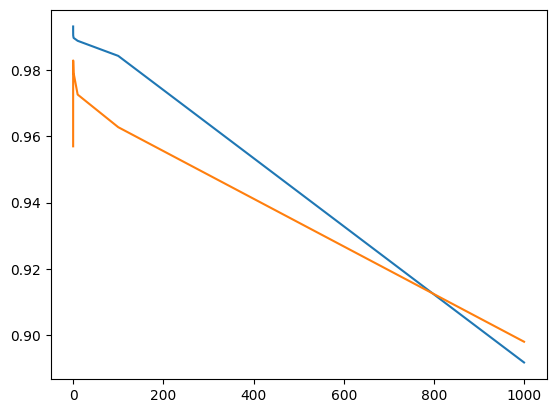

In [98]:
plt.plot(alpha_list,train_scores)
plt.plot(alpha_list,test_scores)
plt.show()

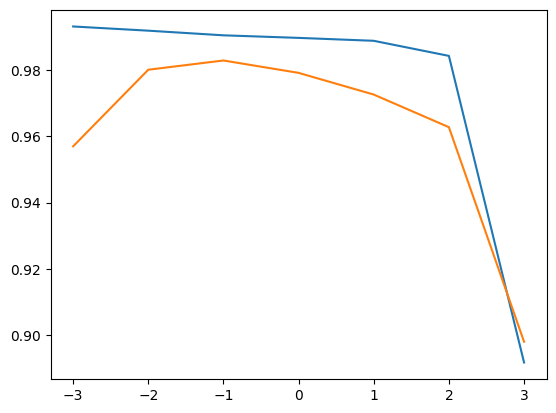

In [99]:
plt.plot(np.log10(alpha_list),train_scores)
plt.plot(np.log10(alpha_list),test_scores)
plt.show()

alpha가 -1인 경우가 train과 test가 제일 가깝다. <- 골디락스 (Goldilocks) 포인트 -1은 0.1이다

In [100]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)
print("Train Score:",ridge.score(train_scaled,train_target))
print("Test Score:",ridge.score(test_scaled,test_target))

Train Score: 0.9903815817570366
Test Score: 0.9827976465386955


---
### L1규제 (Lasso) 회귀
: 가중치의 절대값으로 규제하는 방법

In [101]:
from sklearn.linear_model import Lasso

In [102]:
lasso = Lasso()
lasso.fit(train_scaled,train_target)
print("Train Score:",lasso.score(train_scaled,train_target))
print("Test Score:",lasso.score(test_scaled,test_target))

Train Score: 0.989789897208096
Test Score: 0.9800593698421884


In [103]:
# 최적값 찾기
train_scores = []
test_scores = []
alpha_list = [0.001,0.01,0.1,1,10,100,1000]

for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(train_scaled,train_target)
    train_scores.append(lasso.score(train_scaled,train_target))
    test_scores.append(lasso.score(test_scaled,test_target))

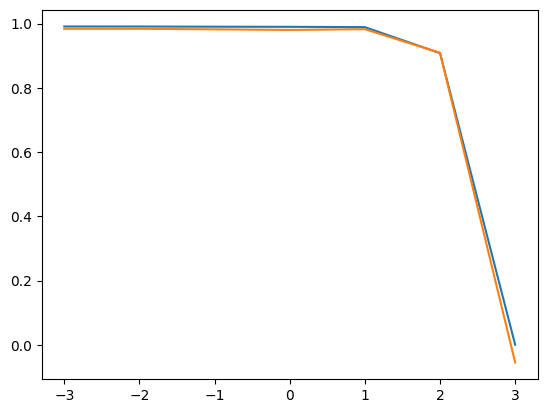

In [104]:
plt.plot(np.log10(alpha_list),train_scores)
plt.plot(np.log10(alpha_list),test_scores)
plt.show()

> 최적값은 1

In [105]:
lasso = Lasso(alpha=1)
lasso.fit(train_scaled,train_target)
print("Train Score:",lasso.score(train_scaled,train_target))
print("Test Score:",lasso.score(test_scaled,test_target))

Train Score: 0.989789897208096
Test Score: 0.9800593698421884


> 단점: lasso인 경우에 기울기 (가중치: weight)를 0으로 변경하는 경우가 발생한다. (완전히 제외되는 특성이 생긴다는 의미)

In [106]:
# 기울기가 0인 경우
np.sum(lasso.coef_==0)

43

> 이러한 이유로 Ridge를 많이 사용함.